In [21]:
import numpy as np
import scipy.integrate as spint
import scipy.optimize as spy
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import pint
import fluids

# Fanno Flow Rayleigh Flow Integrator

In [22]:
# Unit Conversions and Formats Graphs
u = pint.UnitRegistry(autoconvert_offset_to_baseunit=True)
u.setup_matplotlib()
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [23]:
# Givens
T1 = 300
P1 = 101325
epsilon = fluids.material_roughness('aluminum')
D = (0.5 * u.inches).to('meters').magnitude
rho = CP.PropsSI('D', 'T', T1, 'P', P1, 'helium')
visc = CP.PropsSI('V', 'T', T1, 'P', P1, 'helium')
vel = 40
Re = rho * vel * D / visc

gamma = CP.PropsSI('isentropic_expansion_coefficient', 'T', T1, 'P', P1, 'helium')
Ru = CP.PropsSI('gas_constant', 'T', T1, 'P', P1, 'helium') * 1000
Cp = CP.PropsSI('CP0MASS', 'T', T1, 'P', P1, 'helium')
MW = CP.PropsSI('M', 'T', T1, 'P', P1, 'helium') * 1000
R = Ru / MW

a1 = np.sqrt(gamma * R * T1)
M1 = vel / a1


rho = P1 / R / T1

print(gamma)
print(Ru)
print(MW)
print(a1)
print(M1)
print(Cp)

1.6673472439755477
8314.4598
4.002602
1019.3409471538088
0.03924104109786574
5193.159224924187


In [24]:
fluids.friction_factor(Re=Re, eD=epsilon/D)

0.04262461175028646

In [25]:
test = 1 * u.kg / u.m**3
test1 = 1 * u.m / u.s
test2 = 1 * u.J / u.kg / u.degreeK
test3 = 1 * u.degreeK

(test * test1 * test2 * test3)

1.0 <Unit('joule / meter ** 2 / second')>

In [26]:
# Friction Factor Calculations
fricFactorNormFunc = lambda f : -2.0 * np.log10(epsilon / (3.7 * D) + 2.51 / (Re * np.sqrt(f))) - 1 / np.sqrt(f)
fricFactorFannoFunc = lambda f : -4.0 * np.log10(epsilon / (3.7 * D) + 1.255 / (Re * np.sqrt(f))) - 1 / np.sqrt(f)

fricFactorNorm = spy.fsolve(fricFactorNormFunc, 0.01)
fricFactorFanno = spy.fsolve(fricFactorFannoFunc, 0.01)

print(fricFactorNorm)
print(fricFactorFanno)
print(fricFactorFanno * 4)


f = (0.790 * np.log(Re) - 1.64)**(-2)
print(f)

Pr = CP.PropsSI('Prandtl', 'T', T1, 'P', P1, 'helium')

Nu1 = 0.023 * Re ** 0.8 * Pr ** 0.3
Nu2 = 0.125 * f * Re * Pr**(1/3)
print(Nu1)
print(Nu2)

[0.04262461]
[0.01065615]
[0.04262461]
0.040978487600330384
15.925705633901227
18.50764020194254


Text(0.5, 0, 'Mach Number')

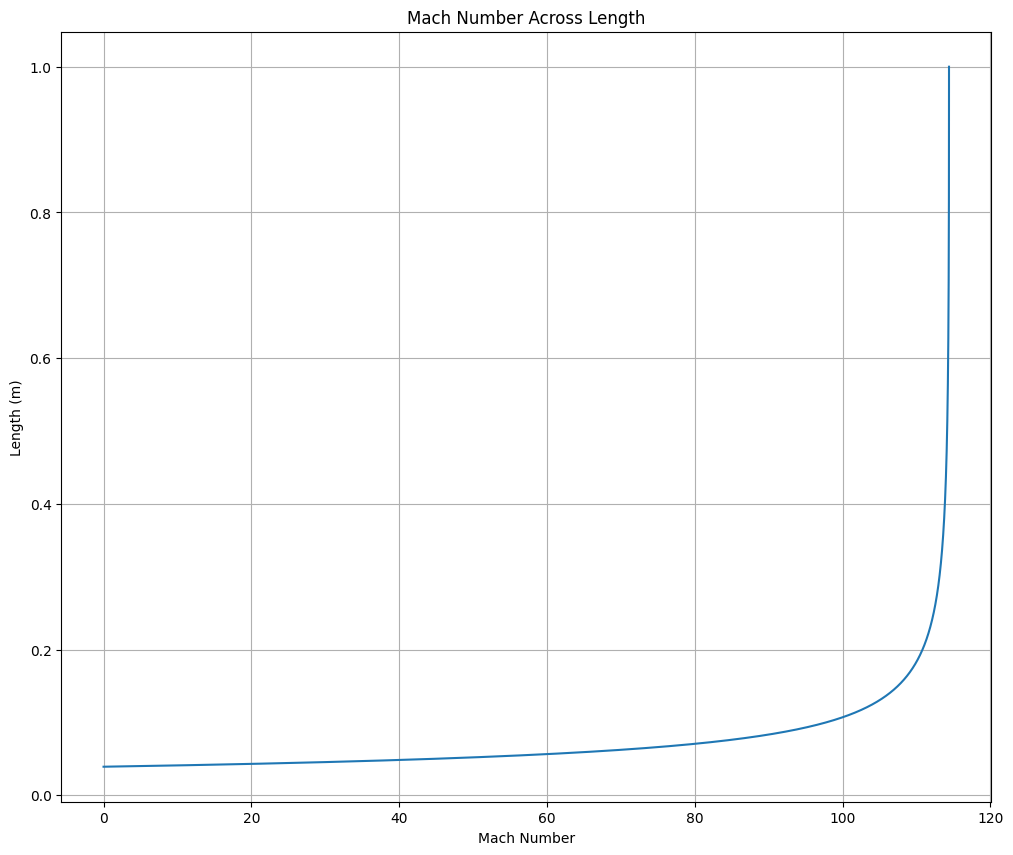

In [27]:
# General Analytical Solving
M2 = np.linspace(M1, 1, 100000)

strangeNum = 1 + (gamma - 1) / 2 * M2**2
strangeDen = 1 + (gamma - 1) / 2 * M1**2

L = (D / (4 * fricFactorFanno)) * ((1 / gamma) * (1 / M1**2 - 1 / M2**2) + (gamma + 1) / (2 * gamma) * np.log((M1**2 / M2**2) * (strangeNum / strangeDen)))
Tanalytical = T1 * ((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
Panalytical = P1 * (M1 / M2) * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
Vanalytical = vel * M2 / M1 * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
RHOanalytical = rho * (M2 / M1 * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2))))**-1

plt.plot(L, M2)
plt.grid()
plt.title('Mach Number Across Length')
plt.ylabel('Length (m)')
plt.xlabel('Mach Number')
# plt.xlim([0.2,1.1])
# plt.ylim([115,122])

In [28]:
L[-1]

114.39401104705063

In [29]:
max(L)

114.39401104705063

Numerical Integration Time :)

In [30]:
# def xdotSolve(t, x, f, D, gamma, D_arr, x_arr, visc):
def xdotSolve(t, x, D_arr, gamma, x_arr, q, Cp):
    # Makes Variables easier to use
    M = x[0]
    V = x[1]
    P0 = x[2]
    P = x[3]
    T01 = x[4]
    T = x[5]
    rho = x[6]

    index = np.searchsorted(x_arr, t)
    if index < len(x_arr):
        if x_arr[index] == t:
            D = D_arr[index]
            dD_dx = (D_arr[index] - D_arr[index-1]) / (x_arr[index] - x_arr[index-1]) if index != 0 else 0
        else:
            D = D_arr[index-1] + (t - x_arr[index-1]) * (D_arr[index] - D_arr[index-1]) / (x_arr[index] - x_arr[index-1])
            dD_dx = (D_arr[index] - D_arr[index-1]) / (x_arr[index] - x_arr[index-1]) if index != 0 else 0
    else:
        D = D_arr[-1]
        index = len(x_arr) - 1
        dD_dx = 0
        
    
    # Solves for friction factor
    Re = rho * V * D / visc
    frictionFactorFunc = lambda f : -4.0 * np.log10(epsilon / (3.7 * D) + 1.255 / (Re * np.sqrt(f))) - 1 / np.sqrt(f)
    # fricFactorPenalty = lambda f, init_guess : frictionFactorFunc(f) + np.power(max([0, init_guess - f]), 2)
    # f = spy.fsolve(func=frictionFactorFunc, 
    #                x0=0.0001)
    # This does not use the classic solver approach but is close enough
    # as numerically solving natural logs suck
    f = fluids.friction_factor(Re = Re, eD=epsilon/D) / 4
    print(f)

    # Area Calculations
    area = (1 / 4) * np.pi * np.power(D, 2)
    dA_dx = 2 * area / D * dD_dx

    # Stagnation Temperature
    dT0_dx = T01 * q / Cp

    # Mach Number (this will drive the rest of the derivations)
    # Done
    num1Area = -M * (1 + (gamma - 1) / 2 * np.power(M, 2))
    den1Area = area * (1 - np.power(M, 2))
    num1 = 4 * f * gamma * np.power(M, 3) * (1 + ((gamma - 1) / 2) * np.power(M, 2))
    den1 = 2 * D * (1 - np.power(M, 2))
    dM_dx = dA_dx * num1Area / den1Area + num1 / den1
    # xdot1 = num1 / den1

    # Velocity
    # Done
    num2 = dM_dx / M
    den2 = 1 + (gamma - 1) / 2 * np.power(M, 2)
    dV_dx =  V * num2 / den2

    # Stagnation Pressure
    # Done
    part31 = - gamma * np.power(M, 2) * 4 * f / (2 * D)
    part32 = - gamma * np.power(M, 2) * dT0_dx / (2 * T01)
    dP0_dx = P0 * (part31 + part32)
    # xdot3 = 0

    # Static Pressure
    # Done
    num4 = -gamma * M * dM_dx
    den4 = 1 + (gamma - 1) / 2 * np.power(M, 2)
    dP_dx = P * (dP0_dx / P0 + num4 / den4)

    # Temperature
    # Done
    num6 = - (gamma - 1) * M * dM_dx
    den6 = 1 + (gamma - 1) / 2 * np.power(M, 2)
    dT_dx = T * num6 / den6

    # Density
    # Done for now
    C7 = 2 / (1 - np.power(M, 2))
    part71 = (np.power(M, 2) / 2) * (dA_dx / area) - (4 * f * gamma * np.power(M, 2)) / (4 * D) - (dT0_dx / (2 * T))
    drho_dx = 0

    xdot = np.hstack((dM_dx, dV_dx, dP0_dx, dP_dx, dT0_dx, dT_dx, drho_dx))

    return xdot

# def xdotSolve(t, x, f, D, gamma):
#     # Makes Variables easier to use
#     M = x[0]

#     num = 4 * f * gamma * np.power(M, 4) * (1 + ((gamma - 1) / 2) * np.power(M, 2))
#     den = 2 * D * (1 - np.power(M, 2))
#     xdot1 = num / den # Mach Number
#     xdot = np.hstack((xdot1))
#     return xdot

# ODE Setup
# Setup up For ODE SOlver
xStart = 0.
xEnd = L[-1]
xLen = 100000
xspan = np.linspace(xStart, xEnd, xLen)

# Geometry Array
D_arr1 = np.linspace(0.013, D, int(xLen/5))
D_arr2 = D * np.ones(int(3 * xLen / 5))
D_arr3 = np.linspace(D, 0.05, int(xLen / 5))
D_arr = np.hstack([D_arr1, D_arr2, D_arr3])
# D_arr = D * np.ones(xLen)

# Heat Transfer
q = -5

# print(len(D_arr))

# Setting Up initial conditions
P01 = P1 * (1 + (gamma - 1) / 2 * np.power(M1, 2)) ** (gamma / (gamma - 1))
T01 = T1 * (1 + (gamma - 1) / 2 * np.power(M1, 2))
IC = np.array([M1, vel, P01, P1, T01, T1, rho])

# ODE Solver Call
# print(IC)
x = spint.solve_ivp(fun=xdotSolve, 
                  t_span=[xStart, xEnd], 
                  y0=IC,
                  args=(D_arr, gamma, xspan, q, Cp),
                  method='RK45', 
                  t_eval=xspan, 
                  rtol=1e-10,
                  atol=1e-10)
# print(x.y)
length = x.t
Mach = x.y[0]
Vel = x.y[1]
P0 = x.y[2]
P = x.y[3]
T0 = x.y[4]
T = x.y[5]
rhoArr = x.y[6]


print(len(Mach))
print(Mach[-1])

0.01057699104808482
0.010554486985547876
0.010576971808229018
0.010576947023233656
0.010576926053916582
0.010577044587809616
0.01057701923833923
0.010576833585870384
0.010576984391265216
0.01057697581606695
0.010576968564379565
0.010577009580669717
0.010577000811407979
0.010576936569656784
0.01057698820012141
0.010576984531449557
0.010576981429440583
0.010576998977891224
0.01057699522635447
0.010576967741045376
0.010576989604131037
0.010576987744072206
0.010576986171399037
0.010576995068799054
0.010576993166756686
0.010576979231169344
0.01057699020945521
0.010576989129158347
0.010576988215791455
0.010576993383313834
0.010576992278640989
0.010576984184986463
0.010576990505103995
0.010576989805653171
0.010576989214289524
0.01057699256007286
0.01057699184484188
0.0105769866044933
0.01057699066459281
0.010576990170590602
0.01057698975292974
0.010576992115965302
0.010576991610818922
0.01057698790970327
0.010576990757726687
0.010576990383696652
0.010576990067468959
0.010576991856625285
0.010

In [42]:
xdotSolve(0, IC, D_arr, gamma, xspan, q, Cp)

0.01057699104808482


array([ 1.64281536e-04,  1.67372899e-01, -4.23741859e+02, -4.24286924e+02,
       -2.88989929e-01, -1.28996912e-03,  0.00000000e+00])

In [32]:
T0

array([300.15414313, 300.15381254, 300.15348195, ..., 268.85151082,
       268.85121471, 268.85091859])

In [33]:
# 14.3487118
test1 = (1 / 4) * np.pi * np.power(D_arr1[0], 2)
test2 = (1 / 4) * np.pi * np.power(D_arr1[-1], 2)
test1 / test2

1.0478020956041914

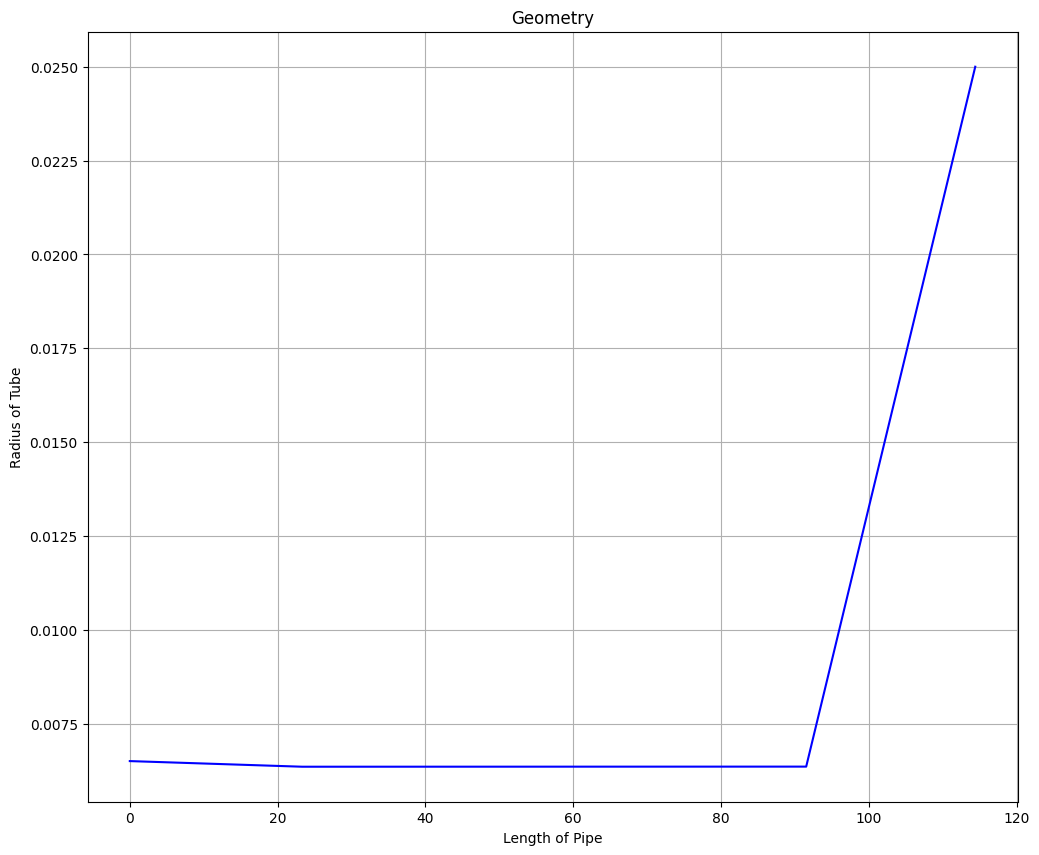

In [34]:
plt.plot(xspan, D_arr/2, color='Blue')
plt.title('Geometry')
plt.xlabel('Length of Pipe')
plt.ylabel('Radius of Tube')
plt.grid()
# plt.gca().set_aspect('equal')

Text(0.5, 1.0, 'Pipe Length')

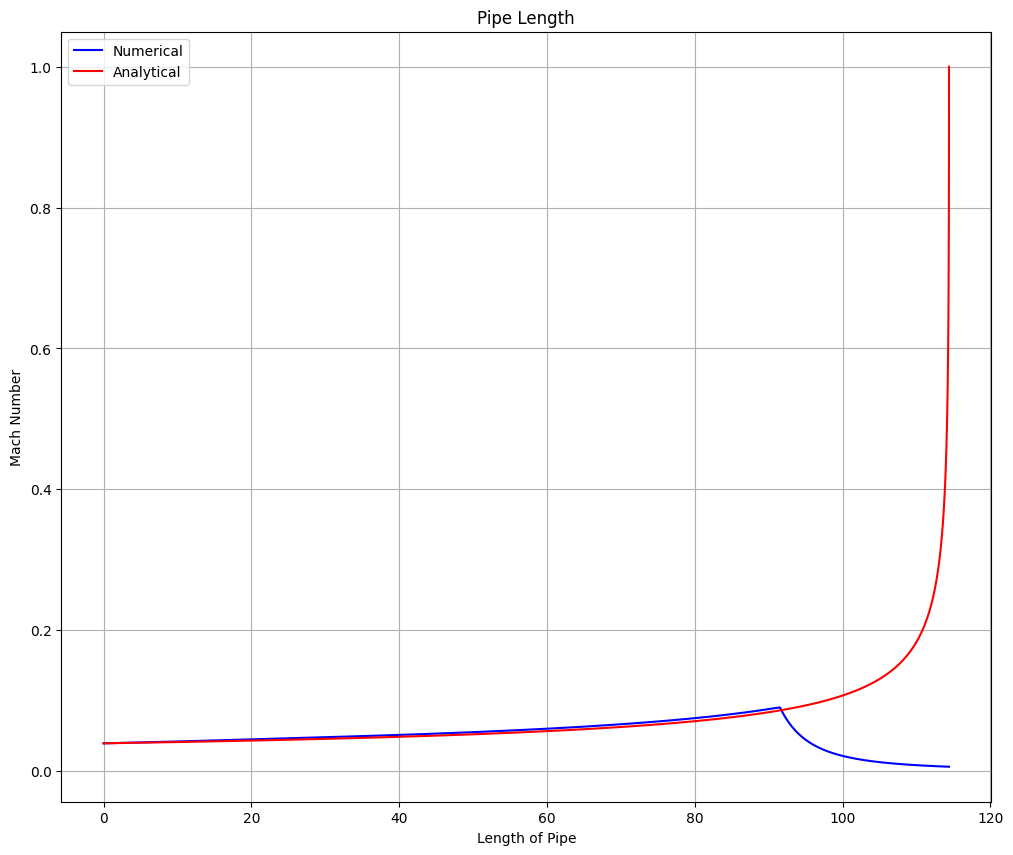

In [35]:
plt.plot(length, Mach, color='Blue', label='Numerical')
plt.plot(L, M2, color='Red', label='Analytical')
plt.grid()
plt.legend()
plt.ylabel('Mach Number')
plt.xlabel('Length of Pipe')
plt.title('Pipe Length')

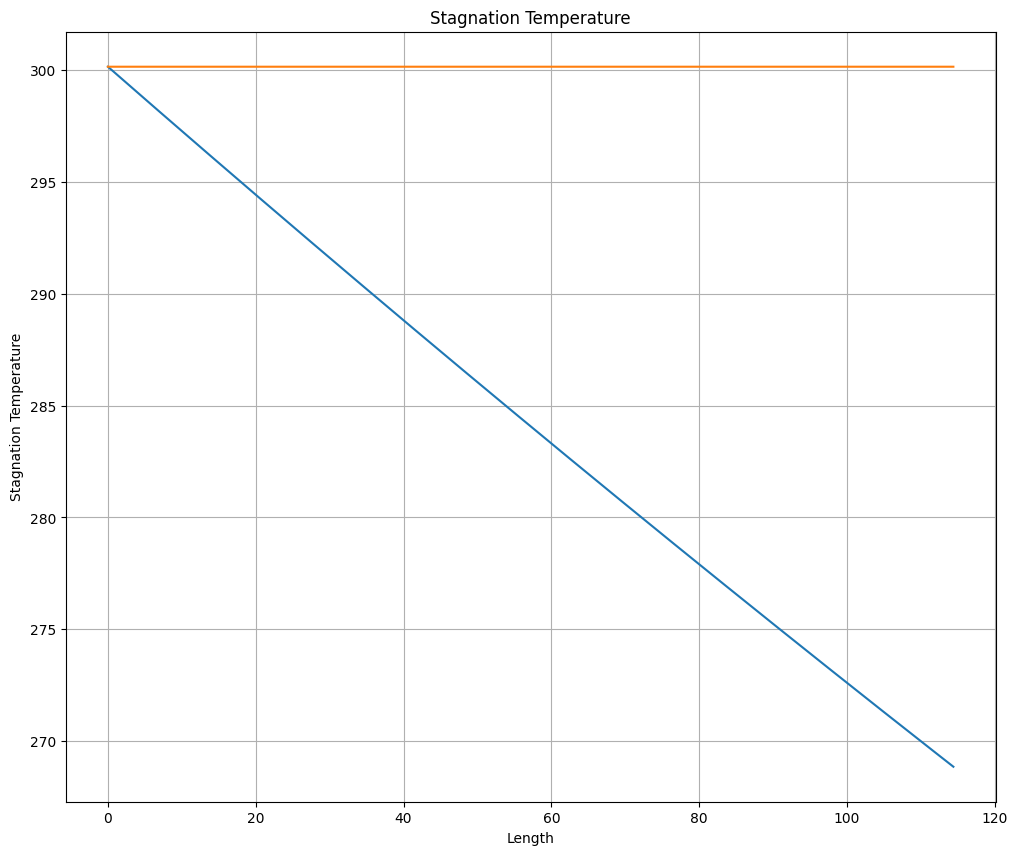

In [36]:
T0test = T * (1 + (gamma - 1) / 2 * Mach**2)
plt.plot(length, T0)
plt.plot(length, T0test)
# plt.ylim([T0[0]-0.1, T0[0]+0.1])
plt.xlabel('Length')
plt.ylabel('Stagnation Temperature')
plt.title('Stagnation Temperature')
plt.grid()

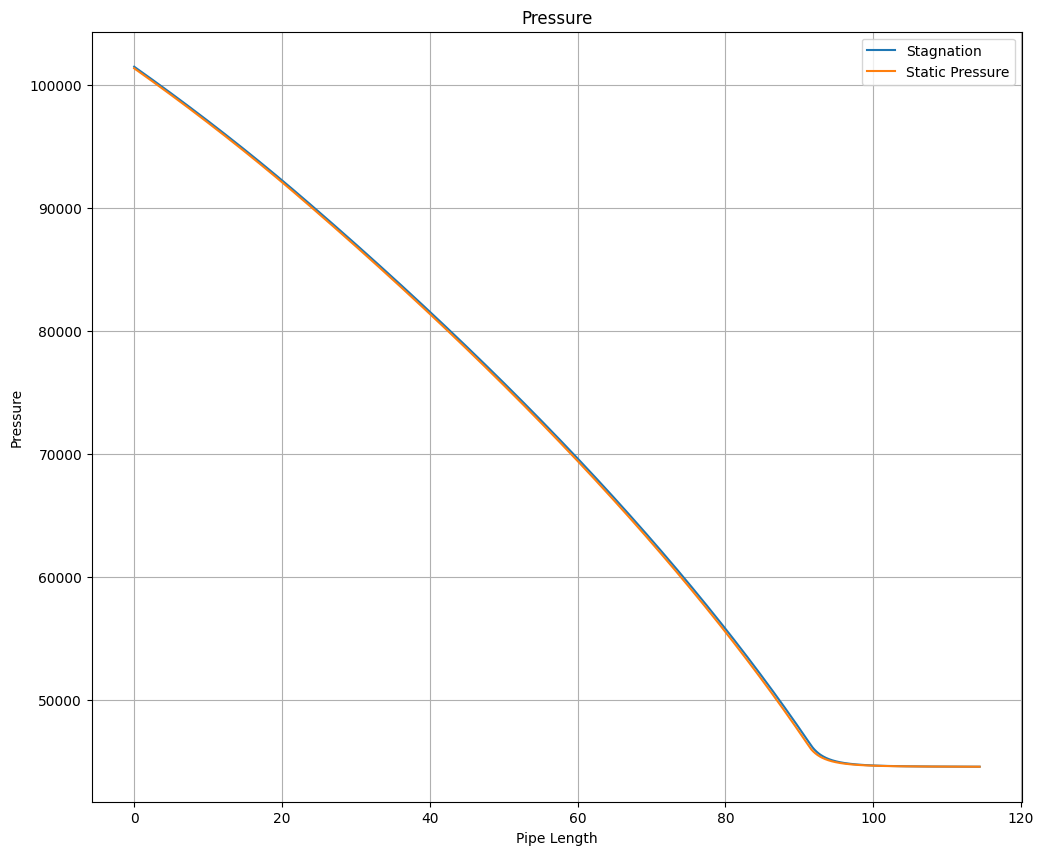

In [37]:
# P0 = P * np.power((1 + (gamma - 1) / 2 * Mach**2), gamma/(gamma-1))
plt.plot(length, P0, label='Stagnation')
plt.plot(length, P, label='Static Pressure')
# plt.plot(L, Panalytical, label='Analytical')
plt.title('Pressure')
plt.ylabel('Pressure')
plt.xlabel('Pipe Length')
plt.legend()
plt.grid()
# plt.ylim([P0[0]-0.1, P0[0]+0.1])

300.1504968590373

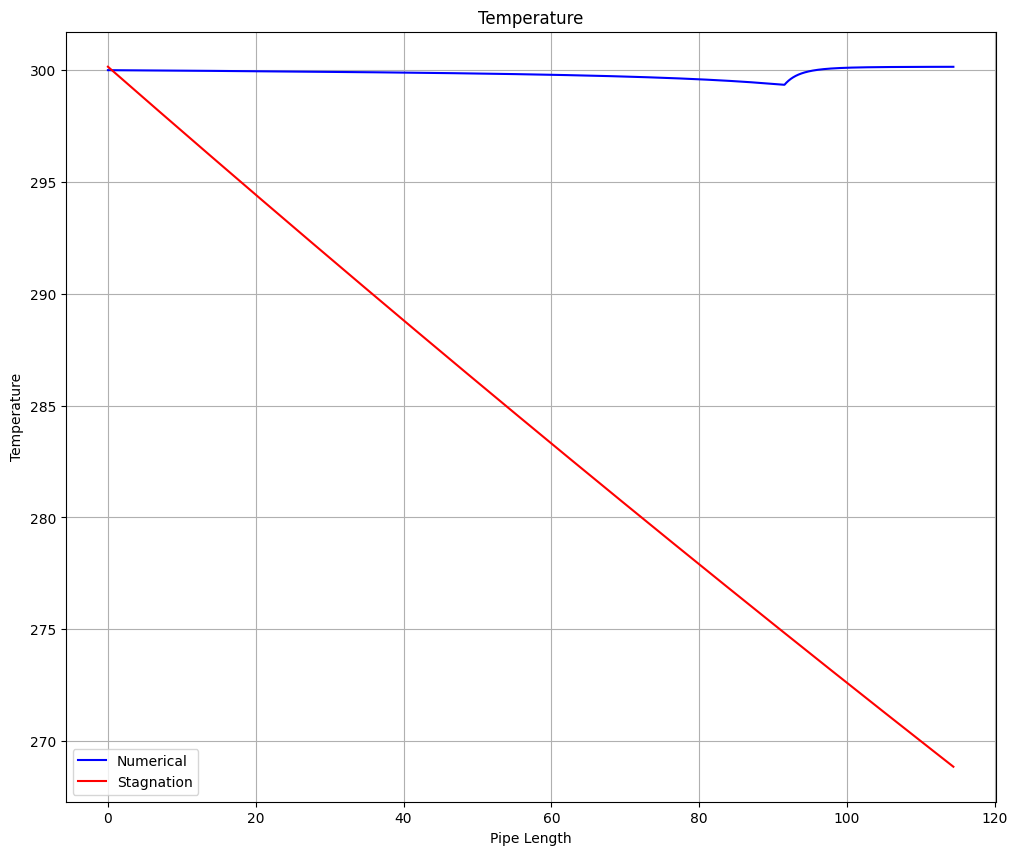

In [38]:
# Temperature
plt.plot(length, T, color='Blue', label='Numerical')
plt.plot(length, T0, color='Red', label='Stagnation')
# plt.plot(length, Tanalytical, color='Red', label='Analytical')
plt.grid()
plt.xlabel('Pipe Length')
plt.ylabel('Temperature')
plt.title('Temperature')
plt.legend()
T[-1]

Text(0.5, 1.0, 'Velocity')

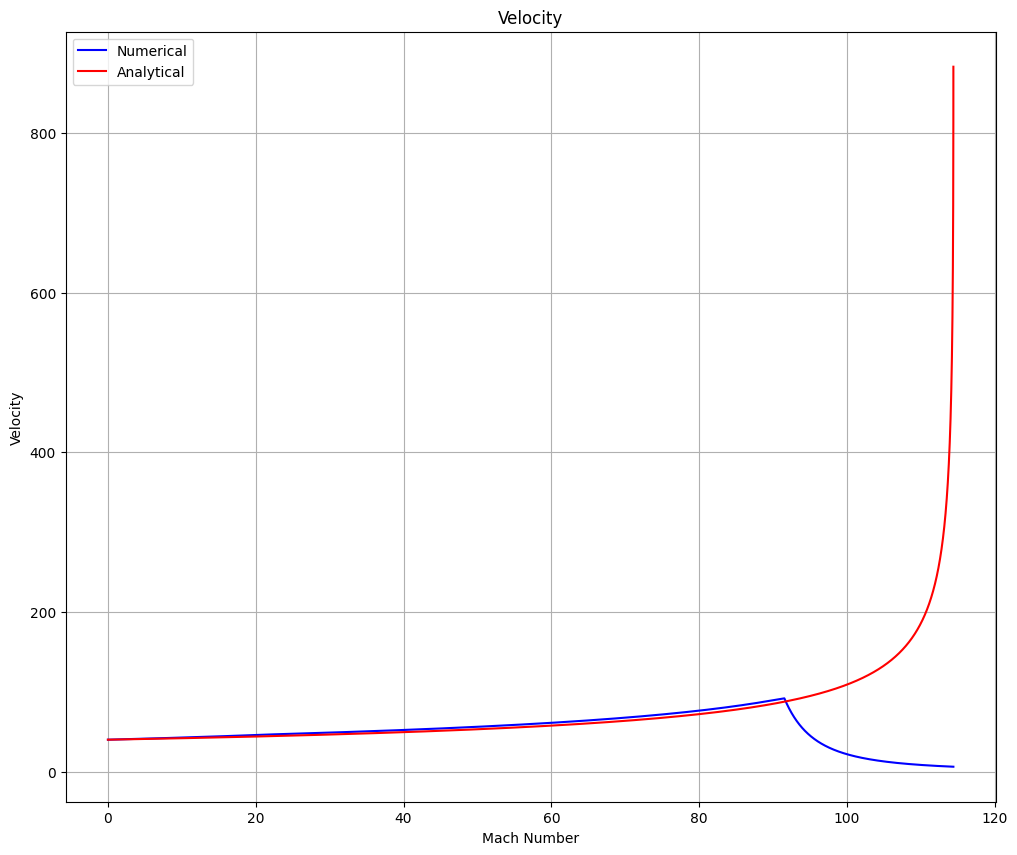

In [39]:
# Velocities
plt.plot(length, Vel, color='Blue', label='Numerical')
plt.plot(L, Vanalytical, color='Red', label='Analytical')
plt.grid()
plt.legend()
plt.xlabel('Mach Number')
plt.ylabel('Velocity')
plt.title('Velocity')

0.16259370518575364
0.16259370518575364
0.16259370518575364


Text(0.5, 1.0, 'Density')

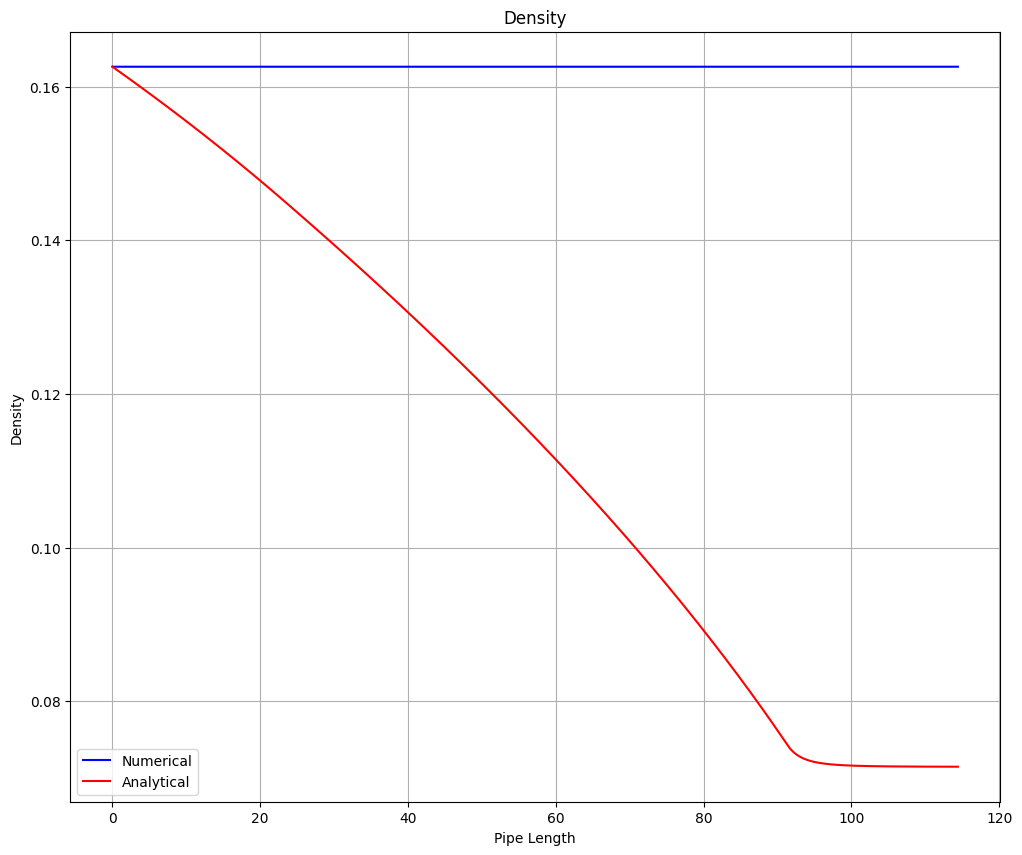

In [40]:
# Densitites
RHOanalytical = P / (R * T)
print(rhoArr[0])
print(rho)
print(RHOanalytical[0])
plt.plot(length, rhoArr, color='Blue', label='Numerical')
plt.plot(length, RHOanalytical, color='Red', label='Analytical')
plt.grid()
plt.legend()
plt.xlabel('Pipe Length')
plt.ylabel('Density')
plt.title('Density')
# plt.xlim([0, 80])
# plt.ylim([0, 0.3])

In [41]:
display('1/gamma(1/M1^2-1/M2^2)+(gamma+1)/(2gamma)ln((M1^2/M2^2)((1+(gamma-1)/2M2^2)/(1+(gamma-1)/2M1^2)))', )

'1/gamma(1/M1^2-1/M2^2)+(gamma+1)/(2gamma)ln((M1^2/M2^2)((1+(gamma-1)/2M2^2)/(1+(gamma-1)/2M1^2)))'